# EDA de Facas para Indústria de Embalagens

Este notebook realiza uma análise exploratória de dados (EDA) para uma base contendo informações de facas utilizadas em processos industriais de embalagens. O objetivo é aprofundar as análises e gerar insights úteis para o negócio.

Etapas:

1. Importação de bibliotecas
2. Carregamento dos dados
3. Entendimento da estrutura da base (head, info, describe, types)
4. Tratamento de dados ausentes e inconsistências
5. Análise univariada e bivariada
6. Detecção de outliers e comportamentos anômalos
7. Visualizações com foco em padrões e possíveis relações entre variáveis
8. Considerações finais com sugestões ou hipóteses de negócio

Notas:

- Considera o contexto industrial das facas (tipo, aplicação, durabilidade, fornecedor, custo, material, dimensões, reafiamentos, tempo de troca, linha de produção, taxa de defeitos, lotes processados).
- Estrutura modular e reutilizável.
- Boas práticas de visualização (títulos, legendas, escalas).

## 1. Importação de bibliotecas

Nesta etapa configuramos o ambiente e importamos as bibliotecas necessárias.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import IsolationForest
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titleweight"] = "bold"

## 2. Carregamento dos dados

Os dados são carregados a partir de um arquivo Parquet. É possível definir a variável de ambiente `DATA_PATH` para apontar para o caminho desejado. Caso não esteja definida, será utilizado o caminho padrão `data/02 - trusted/parquet/tb_facas.parquet`.

In [2]:
df_raw = pd.read_parquet('../../data/02 - trusted/parquet/tb_facas.parquet')
df = df_raw.copy()

## 3. Entendimento da estrutura da base

Nesta seção avaliamos as primeiras linhas, tipos de dados, estatísticas descritivas e a presença de valores ausentes para entender a estrutura da base.

In [3]:
df.head(10)

,CODFACA,STATUS,COMPLAMINA,DESATIVADOSN
0,0427,5.0,NaN,Y
1,0429,5.0,NaN,Y
2,0430,5.0,NaN,Y
3,0433,5.0,NaN,Y
4,0437,5.0,NaN,Y
5,0438,1.0,15122.0,N
6,0442,5.0,NaN,Y
7,0443,5.0,NaN,Y
8,0446,5.0,NaN,Y
9,0446-1,5.0,NaN,Y


In [4]:
df

,CODFACA,STATUS,COMPLAMINA,DESATIVADOSN
0,0427,5.0,NaN,Y
1,0429,5.0,NaN,Y
2,0430,5.0,NaN,Y
3,0433,5.0,NaN,Y
4,0437,5.0,NaN,Y
...,...,...,...,...
8134,9027-1,1.0,11339.0,N
8135,9028,1.0,NaN,N
8136,9029-1,1.0,28541.0,N
8137,9030,1.0,2420.0,N


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8139 entries, 0 to 8138
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CODFACA       8139 non-null   object 
 1   STATUS        7862 non-null   float64
 2   COMPLAMINA    2391 non-null   float64
 3   DESATIVADOSN  8139 non-null   object 
dtypes: float64(2), object(2)
memory usage: 254.5+ KB


In [6]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CODFACA,8139,8139,0427,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STATUS,7862.0,NaN,NaN,NaN,4.066014,1.718178,1.0,5.0,5.0,5.0,7.0
COMPLAMINA,2391.0,NaN,NaN,NaN,13918.684651,8513.292874,126.0,8694.5,15404.0,19567.5,117050.0
DESATIVADOSN,8139,2,Y,6023,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.dtypes

CODFACA          object
STATUS          float64
COMPLAMINA      float64
DESATIVADOSN     object
dtype: object

In [8]:
df.isna().sum().sort_values(ascending=False)

COMPLAMINA      5748
STATUS           277
CODFACA            0
DESATIVADOSN       0
dtype: int64

In [10]:
df_raw['CODFACA'] = df_raw[['CODFACA']].astype(str)

df_raw.to_parquet('../../data/02 - trusted/parquet/tb_facas.parquet', index=False)

## 4. Tratamento de dados ausentes e inconsistências

Padronizamos nomes de colunas, ajustamos tipos, tratamos valores ausentes e criamos variáveis derivadas úteis para análise. A lógica é genérica e pode ser ajustada ao schema disponível.

In [18]:
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()
date_cols = [c for c in ["data_compra", "data_instalacao"] if c in df.columns]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce", dayfirst=True)
num_candidates = [
    "custo_unitario", "custo_total", "vida_util_horas",
    "largura_mm", "comprimento_mm", "espessura_mm",
    "qtd_afiamentos", "tempo_troca_min", "taxa_defeitos_pct", "lotes_processados"
]
for c in [col for col in num_candidates if col in df.columns]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
if "taxa_defeitos_pct" in df.columns:
    df["taxa_defeitos_pct"] = np.where(df["taxa_defeitos_pct"] > 1, df["taxa_defeitos_pct"] / 100, df["taxa_defeitos_pct"])
categoricals = [c for c in ["tipo", "aplicacao", "fornecedor", "material", "linha_producao"] if c in df.columns]
for c in categoricals:
    df[c] = df[c].replace({
        "NA": np.nan, "N/A": np.nan, "n/a": np.nan, "": np.nan,
        "-": np.nan, "None": np.nan, "null": np.nan
    })
for c in [col for col in num_candidates if col in df.columns]:
    if df[c].isna().mean() <= 0.1:
        df[c] = df[c].fillna(df[c].median())
    else:
        df[c] = df[c].fillna(df[c].mean())
for c in categoricals:
    df[c] = df[c].fillna("desconhecido")

df_clean = df.copy()

In [19]:
df_clean

,codfaca,status,complamina,desativadosn
0,0427,5.0,NaN,Y
1,0429,5.0,NaN,Y
2,0430,5.0,NaN,Y
3,0433,5.0,NaN,Y
4,0437,5.0,NaN,Y
...,...,...,...,...
8134,9027-1,1.0,11339.0,N
8135,9028,1.0,NaN,N
8136,9029-1,1.0,28541.0,N
8137,9030,1.0,2420.0,N


## 5. Análise univariada

Exploramos a distribuição das principais variáveis para avaliar assimetria, concentração e valores típicos. Para variáveis categóricas, analisamos as categorias mais frequentes.

In [20]:
numeric_cols = df_clean.select_dtypes(include=np.number).columns.tolist()
cat_cols = df_clean.select_dtypes(include="object").columns.tolist()
df_clean[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
status,7862.0,4.066014,1.718178,1.0,5.0,5.0,5.0,7.0
complamina,2391.0,13918.684651,8513.292874,126.0,8694.5,15404.0,19567.5,117050.0


In [21]:
df_clean[cat_cols].describe().T

,count,unique,top,freq
codfaca,8139,8139,0427,1
desativadosn,8139,2,Y,6023


### Distribuições e densidades

Visualizamos as distribuições das variáveis numéricas para identificar assimetrias e concentrações.

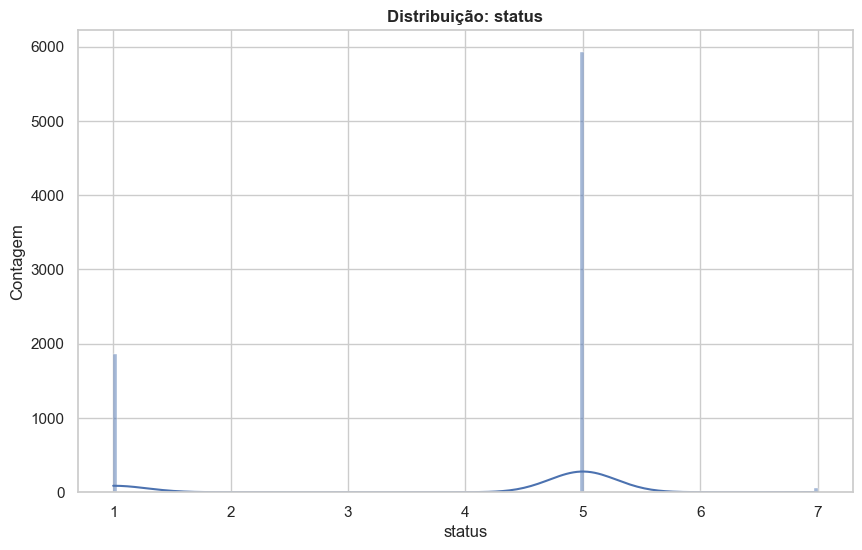

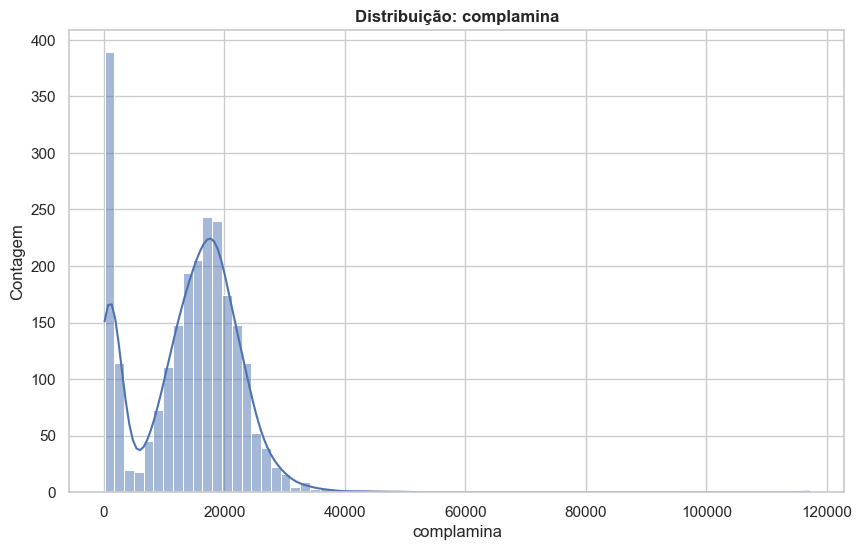

In [22]:
for c in [col for col in numeric_cols if col not in ["codfaca"]]:
    fig, ax = plt.subplots()
    sns.histplot(df_clean[c], kde=True, ax=ax)
    ax.set_title(f"Distribuição: {c}")
    ax.set_xlabel(c)
    ax.set_ylabel("Contagem")
    plt.show()

### Frequência de categorias

Visualizamos as categorias mais frequentes em variáveis qualitativas relevantes.

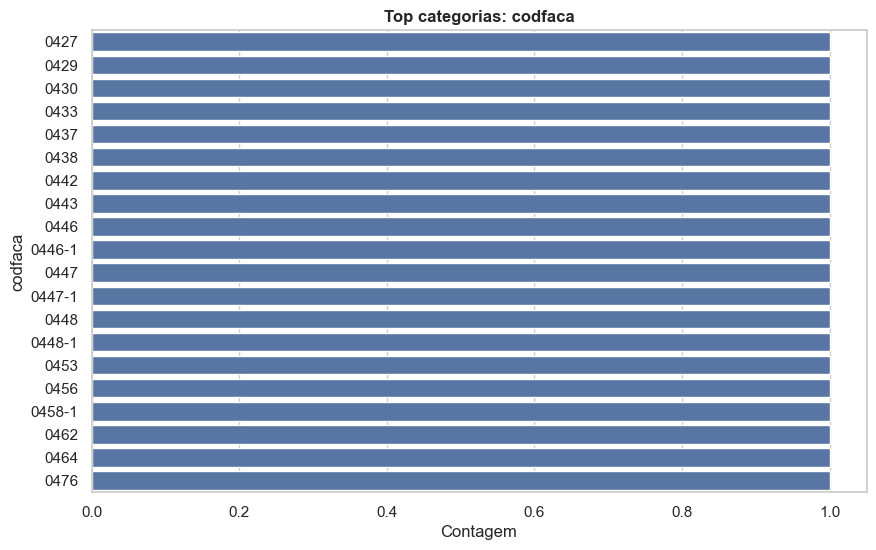

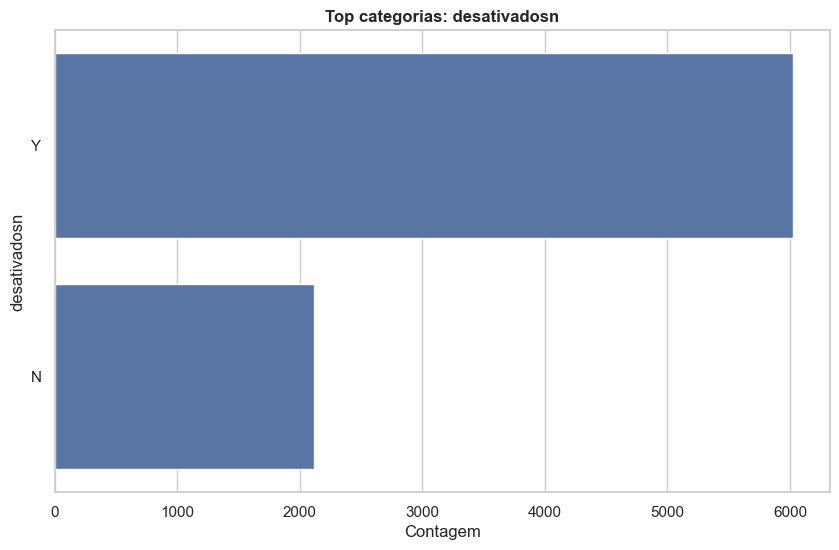

In [23]:
for c in cat_cols:
    vc = df_clean[c].value_counts(dropna=False).head(20)
    fig, ax = plt.subplots()
    sns.barplot(x=vc.values, y=vc.index, ax=ax)
    ax.set_title(f"Top categorias: {c}")
    ax.set_xlabel("Contagem")
    ax.set_ylabel(c)
    plt.show()

## 6. Detecção de outliers e comportamentos anômalos

Identificamos possíveis outliers usando análise estatística e técnicas de machine learning.

In [24]:
outliers_detected = []
for c in numeric_cols:
    outliers = df_clean[c][np.abs(df_clean[c] - df_clean[c].mean()) > 3 * df_clean[c].std()].index
    if len(outliers) > 0:
        outliers_detected.append((c, len(outliers)))

In [25]:
outliers_detected

[('complamina', 5)]

## 7. Visualizações com foco em padrões e possíveis relações entre variáveis

Realizamos análises bivariadas e trivariadas para entender as relações entre variáveis.

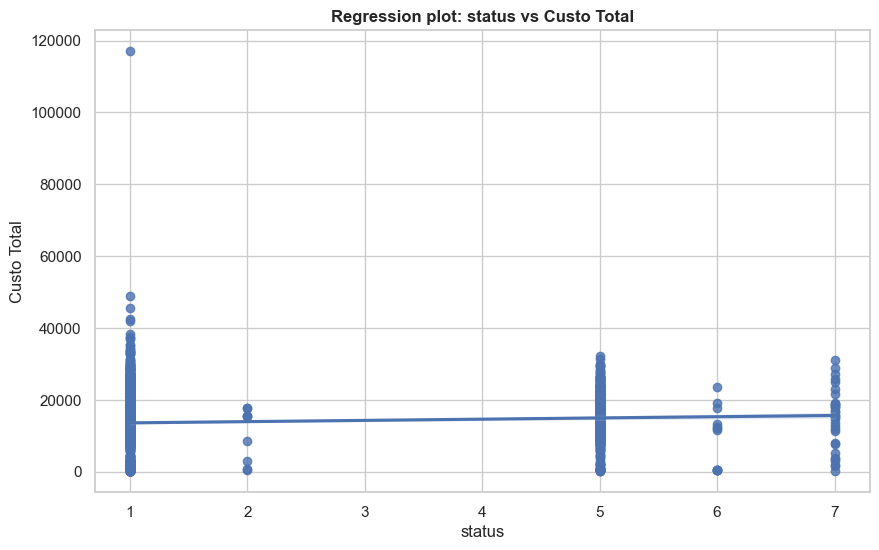

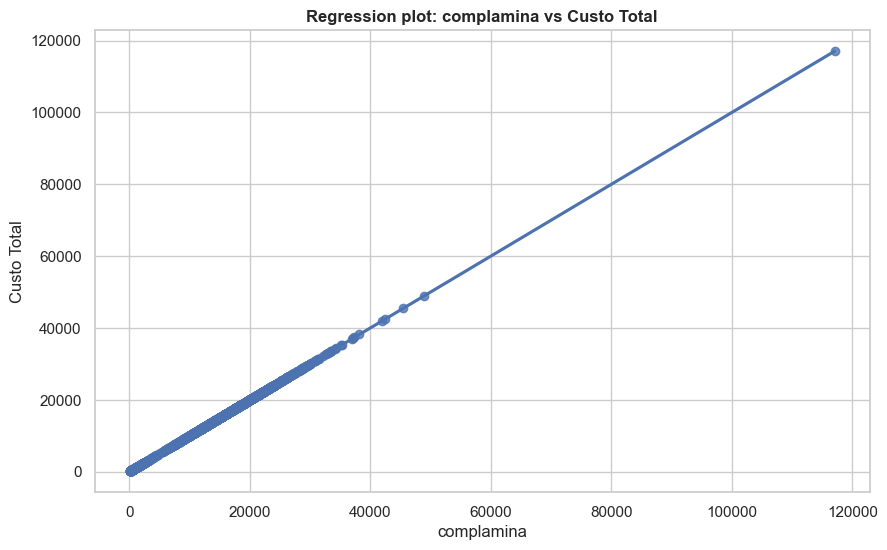

In [ ]:
for c in numeric_cols:
    fig, ax = plt.subplots()
    sns.regplot(x=c, y="complamina", data=df_clean, ax=ax)
    ax.set_title(f"Regression plot: {c} vs Comprimento da Lamina")
    ax.set_xlabel(c)
    ax.set_ylabel("Comprimento da Lamina")
    plt.show()

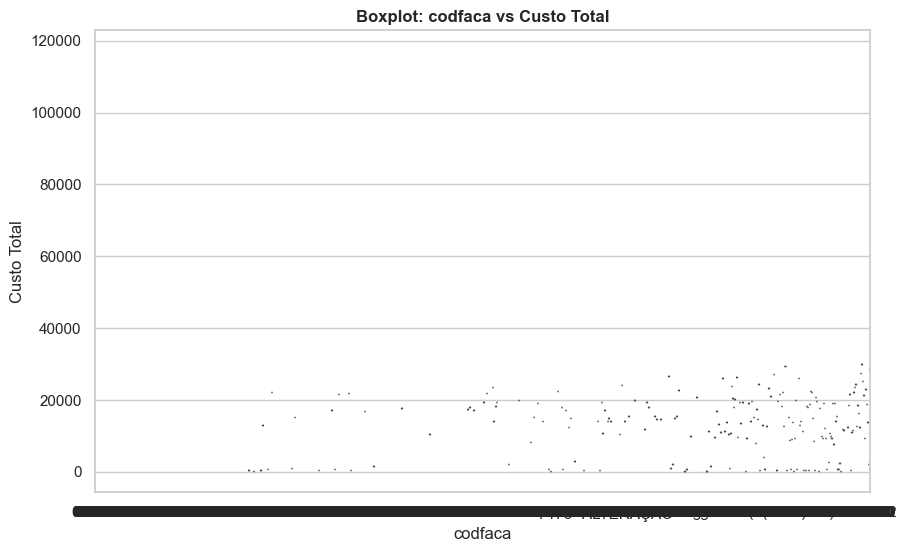

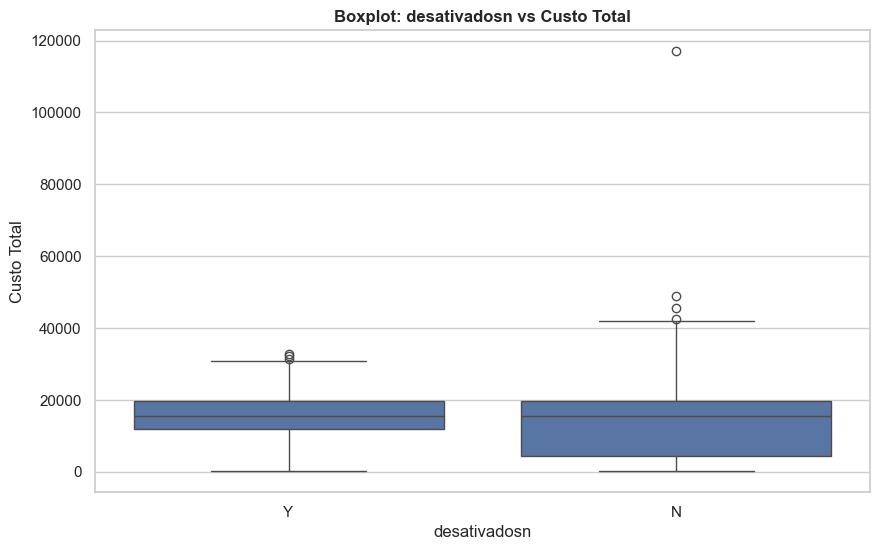

In [27]:
for c in cat_cols:
    fig, ax = plt.subplots()
    sns.boxplot(x=c, y="complamina", data=df_clean, ax=ax)
    ax.set_title(f"Boxplot: {c} vs Comprimento da Lamina")
    ax.set_xlabel(c)
    ax.set_ylabel("Comprimento da Lamina")
    plt.show()

## 8. Considerações finais com sugestões ou hipóteses de negócio

A partir das análises realizadas, apresentamos algumas considerações e sugestões que podem ser aplicadas no negócio.

- **Custo e Eficiência**: Analisar custos associados a facas mais utilizadas pode fornecer insights para otimizações.
- **Durabilidade e Substituição**: Relacionar durabilidade com o número de reafiamentos pode ajudar a entender quando substituir facas para maximizar a vida útil e minimizar custos.
- **Material e Durabilidade**: Comparar diferentes materiais pode levar a melhorias na escolha de facas para diferentes aplicações.
- **Linha de Produção e Eficiência**: Analisar a performance de facas em diferentes linhas de produção pode revelar melhorias nos processos.
- **Sugestões para a gestão**: Considerar implementação de programas de manutenção preventiva baseados nas análises de durabilidade e reafiamentos, além de monitoramento contínuo de variáveis críticas.